In [59]:
# Base
import time
import datetime

# Data Manipulation
import pandas as pd
import polars as pl

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

# Modeling
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Scripts
from Scripts.fetch_utils import fetch_league
from Scripts.analytic_utils import *
from Scripts.scrape_player_stats import *
from Scripts.scrape_team_stats import *
from Scripts.luck_index import *
from Scripts.tidbit_utils import *
from Scripts.simulation_utils import *
#from Scripts.lineup_projections import *

#Fantasy_Pros_Projection_Data = 

# Constants
espn_id = 'AEB61FldCpFLVPDUlhuAq0HiJPhiRqGeqVZoSv1gqxveRGB%2BLzGTtEXE3FIvrPK3qoGrOjXE%2FoKqJADgjzYTsJva22%2BtxhsiEQOiLaBNuh%2FoLLfyY4pewmwNQvDnQ6paTcGaOfktKbZidsvEUc061%2FFYnMxMJ596%2F9HrQQCsbH575%2Bp6bi1Vy80GEVtgjfmp03dSSdjsYoxDMVn403%2BI8rB1HkfFAGcnbbXJq9wVjN6E1xglOkDprydZk5HrX%2FOr7QFt1DBNZHVdv52RO6jEEDTUBGNCYgQgzzTTsl%2FaVw8CgNfilAnku6DzS%2BZFoGhhtw8%3D'
s_id = '{796FF49A-04B4-481F-9132-1F91C9585A05}'

lg_vars = {
    "Winfield_Football": {
        "ID": 521152,
        "ESPN_S2": "AECd6kezzt5c3URGK%2FEHxqSyREcJWZX7JUHahtPHI8SV8KK13PkZG98FJYsIQ%2FFTiA5YXhcfcaQ7bGRGZZzzgz7BQSci5bFMfx1xPTCM95tyCvx%2BBJgIACFkxz%2B5J3uz0Ez87c1XWV%2FuQB%2FjgXXBRvAZaMIBaSnfJ842nwUpjS4x6U6r6FNi900ORFBxtdKU%2FQ6Bvr6UVZKerid0TdatKkFq0IrRYlFr3npOSWsv5bzIV9uh8HidTJlYx%2Bf3DYqZABpGEZfLeuJyymEQ%2BJjXGbaOAjZhOP%2FRrrqpS0xvYbFiwET2MCEmraBsiJcqWR6VaIM%3D",
        "SWID": "{DC47642F-1CD6-4451-9C5B-08FFE2844F9E}",
        "start": 2016,
        "end": 2024
    },
    "Weenieless_Wanderers": {
        "ID": 537814,
        "ESPN_S2": espn_id,
        "SWID": s_id,
        "start": 2015,
        "end": 2024
    },
    "GOP_Degenerates": {
        "ID": 1727104,
        "ESPN_S2": espn_id,
        "SWID": s_id,
        "start": 2023,
        "end": 2024
    },
    "Knights_FFL": {
        "ID": 1992637246,
        "ESPN_S2": espn_id,
        "SWID": s_id,
        "start": 2022,
        "end": 2024
    },
    "12 Dudes one Cup": {
        "ID": 1895076862,
        "ESPN_S2": "AECd6kezzt5c3URGK%2FEHxqSyREcJWZX7JUHahtPHI8SV8KK13PkZG98FJYsIQ%2FFTiA5YXhcfcaQ7bGRGZZzzgz7BQSci5bFMfx1xPTCM95tyCvx%2BBJgIACFkxz%2B5J3uz0Ez87c1XWV%2FuQB%2FjgXXBRvAZaMIBaSnfJ842nwUpjS4x6U6r6FNi900ORFBxtdKU%2FQ6Bvr6UVZKerid0TdatKkFq0IrRYlFr3npOSWsv5bzIV9uh8HidTJlYx%2Bf3DYqZABpGEZfLeuJyymEQ%2BJjXGbaOAjZhOP%2FRrrqpS0xvYbFiwET2MCEmraBsiJcqWR6VaIM%3D",
        "SWID": "{DC47642F-1CD6-4451-9C5B-08FFE2844F9E}"
    },
    "Big Red Fantasy Football": {
        "ID": 820145,
        "ESPN_S2": "AEBEMc4%2BdfLmeqLeujWJ5vXngkv7UEIRNlCK8we%2BOe%2FPqBZbSlGGHINN%2BFue6%2F1%2BAYun1N%2FFqJTDmim%2FY1N1yZj4PatflCQdsSqvnLUx7l%2FdabKDBTJArnWT8PA9IhKdJAAsZgwC%2FlOKx8mJ7gMp11ppccZF6ycJ8%2FSIeKe65LimLfUERkw7cmRhIaXuFlqTb8qQMcMq9L3cjJv7vnBXa%2F2WD3liCL0Wn6ZmzsCRcTb8VALiRUeIHbgBFL4LET7xFUgxFHNYXmzPUObhwTcKGFQ%2FTGVDNUjHXpR%2BC%2BU2rVnm%2Fw%3D%3D",
        "SWID": "{69874D0A-9596-44FA-A011-A1F2C03C5815}"
    }
}

## 1) Set League ##

In [88]:
select_league = "Knights_FFL" # Winfield_Football, Knights_FFL, GOP_Degenerates, Weenieless_Wanderers

league = fetch_league(
        league_id=lg_vars[select_league]['ID'],
        year=lg_vars[select_league]['end'],
        swid=lg_vars[select_league]['SWID'],
        espn_s2=lg_vars[select_league]['ESPN_S2']
    )

BUILDING 2024 Season For Knights FFL  


### Current Analysis

#### Current Lineup

In [89]:
lineups = get_ply_stats_by_matchup(league_id=lg_vars[select_league]['ID'],
                year=2024,
                swid=lg_vars[select_league]['SWID'],
                espn_s2=lg_vars[select_league]['ESPN_S2'])

free_agents = build_fa_market(league=league)

lineups = pd.concat([lineups, free_agents])

lineups.fillna(0, inplace=True)

lineups = lineups.drop_duplicates(subset=['week', 'player_name'])

BUILDING 2024 Season For Knights FFL  


In [90]:
def change_col_prefix(df, old_pfix, new_pfix):

    df = df
    df.columns = df.columns.str.replace(f'{old_pfix}', new_pfix, regex=False)
    return df

def impute_columns(df, target_prefix, source_prefix):
    target_cols = [col for col in df.columns if col.startswith(target_prefix)]
    source_cols = [col for col in df.columns if col.startswith(source_prefix)]

    for source_col in source_cols:
        # Define the corresponding target column name
        target_col = target_prefix + source_col[len(source_prefix):]
        
        # If the target column does not exist, create it by copying the values from the source column
        if target_col not in df.columns:
            df[target_col] = df[source_col]
        
        # If the target column exists, impute missing values from the source column
        elif source_col in df.columns:
            df[target_col] = df[target_col].fillna(df[source_col])
    
    return df

def create_mean_cols(df, target_prefix, source_prefix, mean_prefix='MEAN_'):
    target_cols = [col for col in df.columns if col.startswith(target_prefix)]
    source_cols = [col for col in df.columns if col.startswith(source_prefix)]

    for source_col in source_cols:
        target_col = target_prefix + source_col[len(source_prefix):]
        mean_col = mean_prefix + source_col[len(source_prefix):]

        if target_col in df.columns and source_col in df.columns:
            df[mean_col] = df[[target_col, source_col]].mean(axis=1)

    df = df[['week', 'player_name', 'primaryPosition','player_active_status']  + list(df.filter(like='MEAN_').columns)]

    return df

def clean_pinny(pinny_path="Data/Projections/Pinnacle/Props/Pinnacle_Props_Week_All.parquet"):

    # Constants
    prop_to_stat={
        "Anytime TD": 'rushingTouchdowns',
        "Rushing Yards": "rushingYards",
        "Receiving Yards": "receivingYards",
        "Receptions": "receivingReceptions",
        "TD Passes": "passingTouchdowns",
        "Completions": "passingCompletions",
        "Pass Attempts": "passingAttempts",
        "Passing Yards": "passingYards"
    }

    imp_to_value={
        "rushingYards": {'max': 0.55, 'min': 0.45, 'base': 2},
        "receivingYards": {'max': 0.55, 'min': 0.45, 'base': 2},
        "receivingReceptions": {'max': 0.6, 'min': 0.44, 'base': 1},
        "passingTouchdowns": {'max': 0.65, 'min': 0.35, 'base': 1},
        "passingCompletions": {'max': 0.55, 'min': 0.45, 'base': 2},
        "passingAttempts": {'max': 0.55, 'min': 0.45, 'base': 2},
        "passingYards": {'max': 0.55, 'min': 0.45, 'base': 2}
    }

    # Load
    raw=pd.read_parquet(pinny_path)

    # Get Stats
    raw.replace({"PropType": prop_to_stat}, inplace=True)

    # Filter
    raw = raw[raw['PropType'].isin(list(prop_to_stat.values()))]

    # Replace NaN in Value with ImpNoVig
    raw['Value'] = raw['Value'].fillna(raw['ImpNoVig'])

    raw = raw[raw['OverUnder'].isin(['Yes', 'Over'])]

    # Mutate
    def calculate_adj_value(row):
        prop_type = row['PropType']
        if prop_type in imp_to_value:
            max_val = imp_to_value[prop_type]['max']
            min_val = imp_to_value[prop_type]['min']
            value = row['Value']
            imp_no_vig = row['ImpNoVig']

            # Calculate the AdjValue
            adj_value = value + ((imp_no_vig - 0.5) / ((max_val - min_val)/2))
        elif prop_type == 'rushingTouchdowns':
            TD1 = row['ImpNoVig']
            TD2 = row['ImpNoVig']*row['ImpNoVig']
            TD3 = row['ImpNoVig']*row['ImpNoVig']*row['ImpNoVig']
            adj_value = TD1+TD2+TD3
        else:
            adj_value = row['Value']

        return adj_value
    
    raw['AdjValue'] = raw.apply(calculate_adj_value, axis=1)


    raw = raw[['week', 'Player', 'PropType', 'AdjValue']]
    raw.columns = ['week', 'player_name', 'statType', 'statValue']

    # Pivot
    clean = raw.pivot_table(index=['week','player_name'], columns='statType', values='statValue', aggfunc='mean').reset_index()

    # Split Touchdowns by Usage (Rushing/Receiving)
    clean['receivingTouchdowns'] = clean['rushingTouchdowns'] * (clean['receivingYards'] / (clean['receivingYards'] + clean['rushingYards']))
    clean['rushingTouchdowns'] = clean['rushingTouchdowns'] - clean['receivingTouchdowns']

    clean.columns = ['week', 'player_name'] + ['proj_' + str(col) for col in clean.columns[2:]]
    clean = clean[['week', 'player_name'] + list(clean.columns[2:-1])]

    # Flatten If Needed
    clean.columns.name = None
    clean.columns = [col if col is not None else 'StatValue' for col in clean.columns]

    #final = proj_to_score(proj_df=clean, col_pfix="PINNY")

    return clean

def get_match_details(df1, df2, keys, check_col2, min_wk, tbl_lab):

    # Only Check Weeks that Exist in Data w/ Projected Stats
    df1 = df1[(df1['week'] == min_wk) & (~df1['primaryPosition'].isin(['D/ST', 'K', 'DL', 'DE', 'LB', 'NT', 'CB', 'S', 'DT', 'DB', 'OLB']))]
    df1 = df1[df1.filter(like='MEAN_').sum(axis=1) > 0]
    #df1 = df1[df1['player_active_status'] == 'active']

    # Option 1 - Count unmatched values
    merged_df = pd.merge(df1, df2, on=keys, how='left')
    unmatched_from_df2 = merged_df[check_col2].isnull().sum()
    
    # If > 0, print more information
    if unmatched_from_df2 > 0:
        print(f'Unmatched from {tbl_lab}: {unmatched_from_df2}')

        merged_df = pd.merge(df1, df2, on=keys, how='left', indicator=True)
        unmatched_rows = merged_df[merged_df['_merge'] != 'both']
        unmatched_count = unmatched_rows.shape[0]
        print(unmatched_rows[['week', 'player_name']])

        # Option 3 - Grouping To get Count
        unmatched_count = merged_df['_merge'].value_counts()
        print(unmatched_count)
        print(" ")
    elif unmatched_from_df2 == 0:
        print(f"All Rows in {tbl_lab} Match")
        print(" ")

def compute_weighted_stats(df, stats_list, weights_dict):
    """
    Compute weighted stats for the given statistics in the DataFrame.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the stats.
    - stats_list (list): A list of stat prefixes to compute.
    - weights_dict (dict): A nested dictionary where keys are stat prefixes and values are dictionaries
                           of sources and their corresponding weights.

    Returns:
    - pd.DataFrame: The updated DataFrame with the new weighted stat columns.
    """
    for stat in stats_list:
        new_column_name = f'TRUE_{stat}'
        df[new_column_name] = 0  # Initialize the new column

        # Check if the stat has specific weights defined
        if stat in weights_dict:
            for source, weight in weights_dict[stat].items():
                # Construct the column name based on the source and stat
                col_name = f"{source}_{stat}"
                if col_name in df.columns:
                    # Add the weighted contribution to the new column
                    df[new_column_name] += df[col_name] * weight
        else:
            # If no specific weights are defined for the stat, use default weights
            for source, weight in weights_dict['default'].items():
                col_name = f"{source}_{stat}"
                if col_name in df.columns:
                    df[new_column_name] += df[col_name] * weight
    
    return df

scores_df = build_scoring_table(league=league)

def proj_to_score(proj_df, col_pfix_list=['ESPN', 'FP', 'MEAN', 'PINNY', 'BOL', 'TRUE'], s_df=scores_df):

    # Update scores in s_df for D/ST positions and specific conditions
    if 1727104 in list(proj_df['league_id'].unique()):
        dp_df = proj_df[proj_df['primaryPosition'].isin(['DL', 'DE', 'LB', 'NT', 'CB', 'S', 'DT', 'DB', 'OLB'])]
        normal_df = proj_df[~proj_df['primaryPosition'].isin(['DL', 'DE', 'LB', 'NT', 'CB', 'S', 'DT', 'DB', 'OLB'])]

        s_df.loc[s_df['id'] == 99, 'points'] = 1
        s_df.loc[s_df['id'] == 109, 'points'] = 0
        s_df.loc[s_df['id'] == 112, 'points'] = 0
        s_df.loc[s_df['id'] == 113, 'points'] = 0
        s_df.loc[s_df['id'] == 95, 'points'] = 1
        s_df.loc[s_df['id'] == 97, 'points'] = 1

        # Iterate over each prefix in the prefix list
        for col_pfix in col_pfix_list:
            # Initialize the score column to 0
            normal_df[f'{col_pfix}_Points'] = 0.0

            # Iterate over each score row in s_df
            for _, score_row in s_df.iterrows():
                col_name = f"{col_pfix}_{score_row['colName']}"

                # If the corresponding stat column exists in proj_df, calculate the weighted score
                if col_name in normal_df.columns:
                    normal_df[f'{col_pfix}_Points'] += normal_df[col_name] * score_row['points']


        # Handle DP 
        s_df.loc[s_df['id'] == 95, 'points'] = 12
        s_df.loc[s_df['id'] == 97, 'points'] = 2
        s_df.loc[s_df['id'] == 99, 'points'] = 10
        s_df.loc[s_df['id'] == 112, 'points'] = 5
        s_df.loc[s_df['id'] == 113, 'points'] = 5
        s_df.loc[s_df['id'] == 109, 'points'] = 1

        # Iterate over each prefix in the prefix list
        for col_pfix in col_pfix_list:
            # Initialize the score column to 0
            dp_df[f'{col_pfix}_Points'] = 0.0

            # Iterate over each score row in s_df
            for _, score_row in s_df.iterrows():
                col_name = f"{col_pfix}_{score_row['colName']}"

                # If the corresponding stat column exists in proj_df, calculate the weighted score
                if col_name in dp_df.columns:
                    dp_df[f'{col_pfix}_Points'] += dp_df[col_name] * score_row['points']

        proj_df = pd.concat([normal_df, dp_df])

    else:
        # Iterate over each prefix in the prefix list
        for col_pfix in col_pfix_list:
            # Initialize the score column to 0
            proj_df[f'{col_pfix}_Points'] = 0.0

            # Iterate over each score row in s_df
            for _, score_row in s_df.iterrows():
                col_name = f"{col_pfix}_{score_row['colName']}"

                # If the corresponding stat column exists in proj_df, calculate the weighted score
                if col_name in proj_df.columns:
                    proj_df[f'{col_pfix}_Points'] += proj_df[col_name] * score_row['points']
    
    return proj_df

def clean_lineups(df=lineups):

    # Get Base of Projections (player_name, week, team, etc.)
    base_cols = ['league_id','year','week', 'team_owner', 'team_name', 'team_division', 'player_name', 'player_id', 'slotPosition', 'primaryPosition', 'eligiblePositions', 'pro_team', 'current_team_id' ,'player_position' ,'player_active_status', 'points', 'projPoints']
    actual_scoring_cols = scores_df['colName'].to_list()
    base = df[base_cols + actual_scoring_cols]

    # Constants

    ## Defensive Positions
    d_pos = ['DL', 'DE', 'LB', 'NT', 'CB', 'S', 'DT', 'DB', 'OLB']

    ## Duplicate Error
    fix_list = ['ESPN_rushingYards', 'ESPN_receivingYards', 'ESPN_passingYards']

    # 1) Combine ESPN and Fantasy Pros Data

    ## a) Build ESPN From Raw Data
    espn_proj = df[['week', 'player_name', 'primaryPosition', 'player_active_status']  + list(df.filter(like='proj_').columns)]
    espn_proj = change_col_prefix(df=espn_proj, old_pfix="proj", new_pfix="ESPN")

    ## b) Build Fantasy Pros From Scrape
    fp_proj = pd.read_parquet("Data/Projections/FantasyPros/FantasyPros_Projections_Week_All.parquet").drop(columns=['STD_FantasyPoints', 'TimeStamp'])
    fp_proj = change_col_prefix(df=fp_proj, old_pfix="proj", new_pfix="FP")

    ## c) Combine ESPN and FP
    trans1_df = espn_proj.merge(fp_proj, how='left', on=['week', 'player_name'])
    get_match_details(df1=espn_proj, df2=fp_proj, keys=["week", "player_name"], check_col2="FP_rushingTouchdowns", min_wk=6, tbl_lab="FantasyPros Table")

    ## d) Correct Error Where ESPN Duplicates Yards
    print("=============================== Correcting ESPN Doubled Yard Projections ===============================")
    print(" ")
    for column in fix_list:
        FP_Col = column.replace("ESPN_", "FP_")
        # Apply with a conditional print statement
        trans1_df[column] = trans1_df.apply(
            lambda row: (
                # Check if the condition is true
                print(f"Player: {row['player_name']}, Week: {row['week']}, "
                      f"Original {column}: {row[column]}, "
                      f"New {column}: {row[column] / 2}") or row[column] / 2
                if (row[column] > (row[FP_Col] * 1.75)) and (row[column] > 40) else row[column]
            ),
            axis=1
        )

    print(" ")
    print("======================================== End Doubled Correction ========================================")
    print(" ")

    ## e) Impute FP with ESPN + Create Means
    trans1_df = impute_columns(trans1_df, target_prefix='FP_', source_prefix='ESPN_')
    mean_df = create_mean_cols(trans1_df, target_prefix='FP_', source_prefix='ESPN_')

    ## f) Retain New ESPN Values For Join With Books + Add To Base
    base = base.merge(trans1_df, on=['week', 'player_name', 'primaryPosition','player_active_status'], how='left')

    ## f) Create Dataframe of Means For Imputing Sportsbook Data
    #mean_df = create_mean_cols(trans1_df, target_prefix='FP_', source_prefix='ESPN_')
    

    # 2) Combine Pinnacle Data With ESPN and Impute
    ## a) Clean Pinnacle Data
    pinny_proj = clean_pinny()
    pinny_proj = change_col_prefix(df=pinny_proj, old_pfix="proj", new_pfix="PINNY")

    ## b) Impute Missing Data From ESPN
    trans2_df = mean_df.merge(pinny_proj, on=["week", "player_name"], how='left')
    get_match_details(df1=mean_df, df2=pinny_proj, keys=["week", "player_name"], check_col2="PINNY_rushingTouchdowns", min_wk=5, tbl_lab="Pinnacle Sportsbook Table")
    trans2_df = impute_columns(trans2_df, target_prefix='PINNY_', source_prefix="MEAN_")
    

    ## c) Slim Columns To Only Pinnacle Data
    trans2_df = trans2_df[['week', 'player_name', 'primaryPosition','player_active_status'] + list(trans2_df.filter(like='PINNY').columns)]
    ## d) Join Slim Transformation Back To Base
    base = base.merge(trans2_df, on=['week', 'player_name', 'primaryPosition','player_active_status'], how='left')


    # 3) Combine BetOnline Data With ESPN and Impute
    bol_proj = pd.read_parquet("Data/Projections/BetOnline/BetOnline_AllProps_Week_All.parquet").drop(columns=['position', 'team'])
    bol_proj = change_col_prefix(df=bol_proj, old_pfix="proj", new_pfix="BOL")

    ## b) Impute Missing Data From ESPN
    trans3_df = mean_df.merge(bol_proj, on=["week", "player_name"], how='left')
    get_match_details(df1=mean_df, df2=bol_proj, keys=["week", "player_name"], check_col2="BOL_rushingTouchdowns", min_wk=5, tbl_lab="BetOnline Sportsbook Table")
    trans3_df = impute_columns(trans3_df, target_prefix='BOL_', source_prefix="MEAN_")

    ## c) Slim Columns To Only BOL Data
    trans3_df = trans3_df[['week', 'player_name', 'primaryPosition','player_active_status'] + list(trans3_df.filter(like='BOL_').columns)]

    ## d) Join Slim Transformation Back To Base
    base = base.merge(trans3_df, on=['week', 'player_name', 'primaryPosition','player_active_status'], how='left')

    ## Clean Missing COlumns
    base = impute_columns(base, target_prefix='PINNY_', source_prefix='MEAN_')
    base = impute_columns(base, target_prefix='BOL_', source_prefix='MEAN_')


    ## 5) Create Aggregate Columns For Each Projection Type (Manual Weights)
    weights_dict = {
        'passingYards': {'ESPN': 0.3,'FP': 0.4,'PINNY': 0.3,'BOL': 0},
        'rushingYards': {'ESPN': 0.2,'FP': 0.3,'PINNY': 0.25,'BOL': 0.25},
        'receivingYards': {'ESPN': 0.2,'FP': 0.3,'PINNY': 0.25,'BOL': 0.25},
        'default': {'ESPN': 0.25,'FP': 0.25,'PINNY': 0.25,'BOL': 0.25}
    }

    final = compute_weighted_stats(df=base, stats_list=actual_scoring_cols, weights_dict=weights_dict)

    ## 6) Build Score Column
    final = proj_to_score(final)

    # a) Adjust For Extra ESPN Stats
    final['adjustment'] = final['projPoints'] - final['ESPN_Points']
    for i in ['ESPN', 'FP', 'MEAN', 'PINNY', 'BOL', 'TRUE']:
        final[f'{i}_Points'] = final['adjustment'] + final[f'{i}_Points']


    ## 7) Build Position Rank Columns
    for i in ['ESPN', 'FP', 'MEAN', 'PINNY', 'BOL', 'TRUE']:
        final[f"{i}_PosRank"] = final.groupby(['week', 'primaryPosition'])[f'{i}_Points'].rank(ascending=False, method='dense')

    # Actual
    final['PosRank'] = final.groupby(['week', 'primaryPosition'])['points'].rank(ascending=False, method='dense')

    return final


LINEUPS = clean_lineups()


All Rows in FantasyPros Table Match
 
=============================== Correcting ESPN Doubled Yard Projections ===============================
 
Player: Antonio Gibson, Week: 1, Original ESPN_rushingYards: 54.5403568, New ESPN_rushingYards: 27.2701784
Player: Jaylen Warren, Week: 6, Original ESPN_rushingYards: 57.58867071, New ESPN_rushingYards: 28.794335355
Player: Chase Brown, Week: 6, Original ESPN_rushingYards: 100.8921436, New ESPN_rushingYards: 50.4460718
Player: Zamir White, Week: 6, Original ESPN_rushingYards: 97.96214781, New ESPN_rushingYards: 48.981073905
Player: Joe Mixon, Week: 6, Original ESPN_rushingYards: 150.4923195, New ESPN_rushingYards: 75.24615975
Player: James Cook, Week: 6, Original ESPN_rushingYards: 143.7479411, New ESPN_rushingYards: 71.87397055
Player: Anthony Richardson, Week: 6, Original ESPN_rushingYards: 76.41605138, New ESPN_rushingYards: 38.20802569
Player: Devin Singletary, Week: 6, Original ESPN_rushingYards: 118.3565325, New ESPN_rushingYards: 59.178

### Algorithims

In [ ]:
import statsmodels.api as sm
def get_weight_by_stat(df, stat):

    train_df = df[(df['week'] < league.current_week) & (df[f"{stat}"] > 0) & (df["player_active_status"] == 'active')]
    test_df = df[df['week'] == league.current_week]

    ## Pull Features

    # Projected Stats
    proj_cols = train_df.filter(like=f'_{stat}').columns
    # Volume Stats
    if "passing" in stat:
        vol_cols = train_df.filter(regex='_passingCompletions').columns
        pos_filter = ['QB']
    elif "rushing" in stat:
        vol_cols = train_df.filter(regex='_rushingAttempts').columns
        pos_filter = ['RB', 'WR']
    elif "receiving" in stat:
        vol_cols = train_df.filter(regex='_receivingReceptions').columns
        pos_filter = ['RB', 'WR', 'TE']
    else:
        vol_cols = []

    train_df = train_df[train_df['primaryPosition'].isin(pos_filter)].reset_index()


    feature_cols = list(proj_cols) + list(vol_cols)
    
    # Features
    X = train_df[feature_cols]
    X = sm.add_constant(X)

    # Target
    y = train_df[f'{stat}']

    # Build Model
    model = sm.OLS(y, X).fit()
    weights = model.params

    # Create Projection
    test_df = test_df[(test_df['primaryPosition'].isin(pos_filter)) & (test_df['player_active_status'] == 'active')]
    test_df[f'PRED_{stat}'] = weights['const'] + sum(test_df[col] * weights[col] for col in feature_cols)
    clean = test_df[['week', 'team_name', 'team_owner', 'player_name', 'primaryPosition', 'player_active_status', f'{stat}'] + list(test_df.filter(like=f'_{stat}').columns)]

    return clean.sort_values(by=[f'PRED_{stat}'], ascending=False)

get_weight_by_stat(df=LINEUPS, stat="receivingYards")

In [ ]:
def peek_proj_stats(stat, wk, pos_filter = ['QB', 'RB', 'WR', 'TE']):
    # Build Dataframe
    FULL=LINEUPS[(LINEUPS['week'] == wk) & LINEUPS['primaryPosition'].isin(pos_filter)]
    SLIM = FULL[['week', 'player_name', 'primaryPosition']  + list(FULL.filter(like=f'{stat}').columns)]
    SLIM = SLIM[SLIM.filter(like=f'{stat}').sum(axis=1) > 0]

    # Create True_Points
    if stat == 'defensiveInterceptions' and "D/ST" not in pos_filter:
         pt_val = 12
    elif stat == 'defensiveSacks' and "D/ST" not in pos_filter:
         pt_val = 10
    elif stat == 'defensiveTotalTackles' and "D/ST" not in pos_filter:
         pt_val = 1
    else:
        pt_val = scores_df[scores_df['colName'] == stat]['points'].iloc[0]

        
    SLIM['true_Points'] = SLIM[f'TRUE_{stat}']*pt_val

    return SLIM.sort_values(by=f'true_Points', ascending=False)

peek_proj_stats(stat='defensiveSacks', wk=6, pos_filter=['DE'])

In [104]:
#def build_prev_proj(df, wk_start = 3, wk_end = 4):
#
#    df = LINEUPS
#    # Create Historical ESPN DF
#    df = df[(df['week'] >= wk_start) & (df['week'] <= wk_end)]
#
#    # Separate Columns
#    rush_cols = list(df.filter(like='rushing').columns)
#    rec_cols =  list(df.filter(like='receiving').columns)
#
#    pass_df = df[['week', 'player_name', 'primaryPosition'] + list(df.filter(like='passing').columns)]
#    pass_df = pass_df[(pass_df['primaryPosition'] == 'QB') & (~pass_df['passingAttempts'].isna())]
#
#    # Cols to Predict
#    points_cols = fp_df.columns.str.replace('FP_', '', regex=False)
#    pred_cols = [col for col in pass_df.columns if 'passing' in col and col in points_cols]
#    print(points_cols)
#    
#
#    return pass_df
    

In [ ]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
def create_ESPN_combo(stat, visualize = True, pos_filter = None):

    # Build Combination Table
    df = LINEUPS
    df['Points'] = df['points']
    df = df[(df['week'] == 5) & (df['week'] == 5) & (~df[f'ESPN_{stat}'].isna())]
    df[f'{stat}'].fillna(0, inplace=True)

    # DF Filter Rows Where Projection is 0 in Pinny
    df = df[df[f'PINNY_{stat}'] > 0]

    if pos_filter is not None:
        df = df[df['primaryPosition'].isin(pos_filter)]

    # Filter any NAs
    df = df.dropna(subset=[f'PINNY_{stat}', f'FP_{stat}'])

    # Build Linear Regression Model
    X = df[[f'ESPN_{stat}', f'FP_{stat}', f'PINNY_{stat}', f'BOL_{stat}']]
    Y = df[f'{stat}']
    model = LinearRegression()
    model.fit(X, Y)
    df[f'COMBO_{stat}'] = model.predict(X)



    # Build Difference Cols
    #df[f"DIFF_ESPN_{stat}"] = df[f"{stat}"] - df[f'ESPN_{stat}']
    #df[f"DIFF_FP_{stat}"] = df[f"{stat}"] - df[f'FP_{stat}']
    #df[f"DIFF_PINNY_{stat}"] = df[f"{stat}"] - df[f'PINNY_{stat}']

    clean = df[['week', 'player_name', f"{stat}", f'ESPN_{stat}', f'FP_{stat}', f'PINNY_{stat}', f'BOL_{stat}', f'TRUE_{stat}', f'COMBO_{stat}']].sort_values(by=[f"{stat}"], ascending=False)

    if visualize == True:

        label_map = {f"TRUE_{stat}": "Average", f"PINNY_{stat}": "Pinnacle Sportsbook", f"BOL_{stat}": "BetOnline Sportsbook", f"ESPN_{stat}": "ESPN", f"FP_{stat}": "FantasyPros", f"COMBO_{stat}": "Model"}

        df_melted = clean.melt(id_vars=['player_name', f'{stat}'], 
                    value_vars=[f'ESPN_{stat}', f'FP_{stat}', f'PINNY_{stat}', f'BOL_{stat}', f'COMBO_{stat}', f'TRUE_{stat}'],
                    var_name='Projection Source', value_name=f'Projected {stat}')
        
        df_melted.replace({"Projection Source": label_map}, inplace=True)

        r2_scores = {}
        for source in df_melted['Projection Source'].unique():
            subset = df_melted[df_melted['Projection Source'] == source]
            r2 = r2_score(subset[f'{stat}'], subset[f'Projected {stat}'])
            r2_scores[source] = r2


        # Plot using seaborn
        plt.figure(figsize=(12, 7))
        sns.scatterplot(x=f'Projected {stat}', y=f'{stat}', hue='Projection Source', data=df_melted, palette='Set1')


        handles, labels = plt.gca().get_legend_handles_labels()
        new_labels = [f'{label} (R² = {r2_scores[label]:.3f})' for label in labels]
        plt.legend(handles, new_labels, title='Projection Source')

        plt.title(f'{stat} vs Projected {stat} by Projection Source')
        plt.xlabel('Projected')
        plt.ylabel('Actual')
        plt.show()

    elif visualize == False:
        return clean

#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)

create_ESPN_combo(stat = "defensiveTotalTackles", pos_filter=['DE', 'LB', 'DT', 'S', 'CB'], visualize=True) #

In [91]:
def check_week(lu, week, own):

    lu['trueDiff'] = lu['TRUE_Points'] - lu['projPoints']

    # Get My Team
    df = lu[(lu['week'] == week) & (lu['team_owner'] == own)][['week', 'team_name', 'player_name', 'slotPosition', 'primaryPosition',
                                                               'points', 'projPoints', 'FP_Points', 'PINNY_Points', 'BOL_Points', 'TRUE_Points', 'trueDiff',
                                                               'PosRank', 'ESPN_PosRank', 'FP_PosRank', 'BOL_PosRank', 'TRUE_PosRank']]

    # Order
    bench = pd.DataFrame([{
        'week': week,
        'team_name': df['team_name'].iloc[0],
        'player_name': 'Total',
        'slotPosition': 'Starting Lineup',
        'primaryPosition': '',
        'points': df[~df['slotPosition'].isin(['BE', 'IR'])]['points'].sum(),
        'projPoints': df[~df['slotPosition'].isin(['BE', 'IR'])]['projPoints'].sum(),
        'FP_Points': df[~df['slotPosition'].isin(['BE', 'IR'])]['FP_Points'].sum(),
        'PINNY_Points': df[~df['slotPosition'].isin(['BE', 'IR'])]['PINNY_Points'].sum(),
        'BOL_Points': df[~df['slotPosition'].isin(['BE', 'IR'])]['BOL_Points'].sum(),
        'TRUE_Points': df[~df['slotPosition'].isin(['BE', 'IR'])]['TRUE_Points'].sum(),
        'trueDiff': df[~df['slotPosition'].isin(['BE', 'IR'])]['trueDiff'].sum(),
        'PosRank': '',
        'ESPN_PosRank': '',
        'FP_PosRank': '',
        'TRUE_PosRank': ''
        
    },
    {
        'week': week,
        'team_name': df['team_name'].iloc[0],
        'player_name': 'Total',
        'slotPosition': 'Bench',
        'primaryPosition': '',
        'points': df[df['slotPosition'].isin(['BE', 'IR'])]['points'].sum(),
        'projPoints': df[df['slotPosition'].isin(['BE', 'IR'])]['projPoints'].sum(),
        'FP_Points': df[df['slotPosition'].isin(['BE', 'IR'])]['FP_Points'].sum(),
        'PINNY_Points': df[df['slotPosition'].isin(['BE', 'IR'])]['PINNY_Points'].sum(),
        'BOL_Points': df[df['slotPosition'].isin(['BE', 'IR'])]['BOL_Points'].sum(),
        'TRUE_Points': df[df['slotPosition'].isin(['BE', 'IR'])]['TRUE_Points'].sum(),
        'trueDiff': df[df['slotPosition'].isin(['BE', 'IR'])]['trueDiff'].sum(),
        'PosRank': '',
        'ESPN_PosRank': '',
        'FP_PosRank': '',
        'TRUE_PosRank': ''
        
    }])

    # Append the summary row to the DataFrame
    df = pd.concat([df, bench], ignore_index=True)

    pos_order = ['QB', 'RB', 'WR', 'TE', 'RB/WR/TE', 'OP', 'DP', 'D/ST', 'K', 'Starting Lineup', 'BE', 'Bench', 'IR']
    order_mapping = {val: idx for idx, val in enumerate(pos_order)}
    df = df.sort_values(by=['slotPosition', 'TRUE_Points'], key=lambda x: x.map(order_mapping))

    return df

check_week(lu = LINEUPS, week = 6, own='Tommy Winfield')

,week,team_name,player_name,slotPosition,primaryPosition,points,projPoints,FP_Points,PINNY_Points,BOL_Points,TRUE_Points,trueDiff,PosRank,ESPN_PosRank,FP_PosRank,BOL_PosRank,TRUE_PosRank
7,6,Senorita Awesome,Caleb Williams,QB,QB,0.0,14.95,15.685282,16.036717,16.919310,16.320028,1.370028,3.0,17.0,17.0,12.0,17.0
1,6,Senorita Awesome,Travis Etienne Jr.,RB,RB,0.0,13.99,12.201882,11.416140,13.144901,12.647516,-1.342484,6.0,18.0,22.0,23.0,23.0
14,6,Senorita Awesome,Roschon Johnson,RB,RB,0.0,7.61,6.731956,6.205199,6.772691,6.822193,-0.787807,6.0,40.0,40.0,46.0,41.0
0,6,Senorita Awesome,Garrett Wilson,WR,WR,0.0,16.62,14.674872,14.537758,14.322591,14.987899,-1.632101,6.0,6.0,11.0,12.0,10.0
4,6,Senorita Awesome,George Pickens,WR,WR,0.0,13.27,13.017745,11.286574,11.054597,12.169311,-1.100689,6.0,24.0,23.0,37.0,27.0
5,6,Senorita Awesome,Dalton Kincaid,TE,TE,0.0,9.58,9.985875,9.782937,10.376327,9.929974,0.349974,3.0,9.0,7.0,7.0,7.0
6,6,Senorita Awesome,Rome Odunze,RB/WR/TE,WR,0.0,10.09,9.687563,8.462212,10.073296,9.563387,-0.526613,6.0,48.0,45.0,46.0,48.0
10,6,Senorita Awesome,Packers D/ST,D/ST,D/ST,0.0,4.88,4.977032,4.928516,4.928516,4.928516,0.048516,2.0,18.0,18.0,18.0,18.0
13,6,Senorita Awesome,Evan McPherson,K,K,0.0,8.06,8.060000,8.060000,8.060000,8.060000,0.000000,3.0,11.0,11.0,11.0,11.0
15,6,Senorita Awesome,Total,Starting Lineup,,0.0,99.05,95.022206,90.716053,95.652228,95.428823,-3.621177,,,,NaN,


In [64]:
def get_league_projections(week, lu=LINEUPS):
    df = lu[(lu['week'] == week) & (lu['team_owner'] != 'Free Agent') & (~lu['slotPosition'].isin(['BE', 'IR']))][['week', 'team_owner', 'team_name',
             'points', 'projPoints', 'TRUE_Points']]
    
    df['TRUE_Points'] = df['TRUE_Points'].fillna(df['projPoints'])

    result = df.groupby(['week', 'team_owner', 'team_name'], as_index=False).agg({
        'points': 'sum',
        'projPoints': 'sum',
        'TRUE_Points': 'sum'
        })
    
    result['point_diff'] = result['TRUE_Points'] - result['projPoints']

    return result.sort_values(by='projPoints', ascending=False)

get_league_projections(week = 6)

,week,team_owner,team_name,points,projPoints,TRUE_Points,point_diff
1,6,Frankie W,Team Frankie,20.0,125.68,123.711963,-1.968037
4,6,Tommy Winfield,Steel Your Face,0.0,124.38,120.940945,-3.439055
5,6,Will Winfield,Willy Wankers,5.0,123.84,119.520684,-4.319316
2,6,Hank Winfield,Online Big Daddy,8.0,121.90,120.999106,-0.900894
0,6,Chaille Winfield,Mama's Boys,0.0,110.95,109.557248,-1.392752
3,6,Jack Winfield,Coconut Crushers,28.0,106.04,101.661011,-4.378989


In [95]:
def get_rankings(pos, week, visualize = False, check_fa = False):
    df = LINEUPS[(LINEUPS['primaryPosition'].isin(pos)) & (LINEUPS['week'] == week)]
    df = df[['week', 'primaryPosition','player_name', 'team_owner', 'team_name',
                  'points', 'projPoints', 'TRUE_Points', 'BOL_Points', 'PosRank', 'ESPN_PosRank', 'TRUE_PosRank']]
    if week != 6:
        df = df.sort_values(by=['PosRank', 'points'])
    else:
        df = df.drop(columns=['points', 'PosRank']).sort_values(by=['TRUE_Points'], ascending=False)

    if visualize == False:
        if check_fa == True:
            return df[df['team_owner'].isin(['Tommy Winfield', 'Free Agent'])]
        else:
            return df
    #elif visualize == True:
        # Set up the figure
        
get_rankings(pos = ['TE'], week = 6, visualize=False, check_fa=True).head(10)


,week,primaryPosition,player_name,team_owner,team_name,projPoints,TRUE_Points,BOL_Points,ESPN_PosRank,TRUE_PosRank
1128,6,TE,Dalton Kincaid,Tommy Winfield,Senorita Awesome,9.58,9.929974,10.376327,9.0,7.0
1385,6,TE,Theo Johnson,Free Agent,Free Agent,7.38,7.445757,7.409561,17.0,18.0
1379,6,TE,Hunter Henry,Free Agent,Free Agent,6.32,6.902639,7.512918,21.0,19.0
1381,6,TE,Juwan Johnson,Free Agent,Free Agent,5.65,6.271301,7.123918,25.0,22.0
1383,6,TE,Erick All Jr.,Free Agent,Free Agent,6.85,5.258834,5.506688,19.0,25.0
1380,6,TE,Chig Okonkwo,Free Agent,Free Agent,4.96,5.169593,5.706962,27.0,26.0
1382,6,TE,Hayden Hurst,Free Agent,Free Agent,5.13,4.686946,5.465290,26.0,27.0
1394,6,TE,Foster Moreau,Free Agent,Free Agent,3.40,3.209388,3.847098,28.0,28.0
1398,6,TE,Luke Schoonmaker,Free Agent,Free Agent,3.19,2.812763,2.777477,29.0,29.0
1395,6,TE,Jordan Akins,Free Agent,Free Agent,1.98,2.420908,2.540057,30.0,30.0


In [94]:
grouped_means = LINEUPS[(LINEUPS['player_active_status'] == 'active') & (LINEUPS['week'] == 5)].groupby('primaryPosition').agg({
    'points': 'mean',
    'projPoints': 'mean',
    'ESPN_Points': 'mean',
    'TRUE_Points': 'mean'
}).reset_index().sort_values(by = ['points'], ascending=False)

grouped_means

,primaryPosition,points,projPoints,ESPN_Points,TRUE_Points
2,QB,17.828000,17.280000,17.280000,16.950970
5,WR,13.250000,12.557963,12.557963,12.128465
4,TE,11.072727,8.418182,8.418182,8.504338
3,RB,10.513043,11.589348,11.589348,11.450573
1,K,9.928571,8.117857,8.117857,8.117857
0,D/ST,6.526316,4.888947,4.888947,4.962861


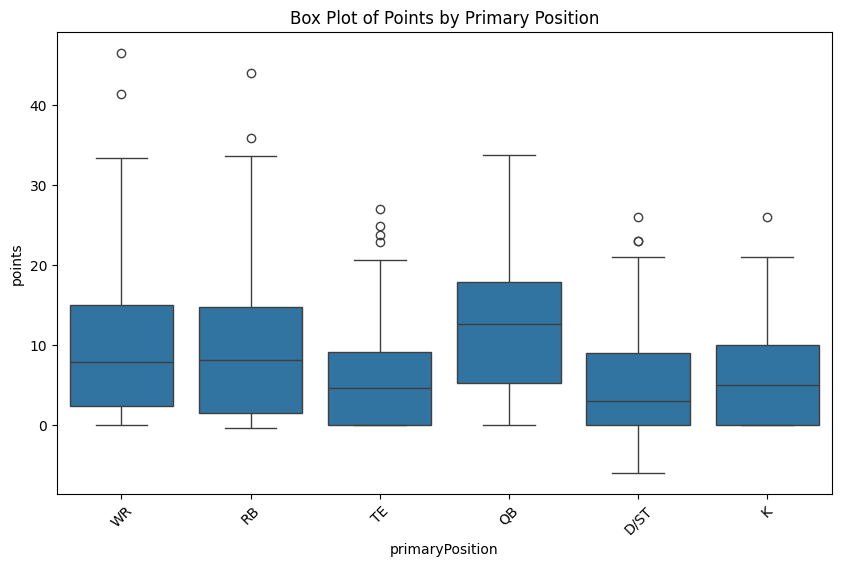

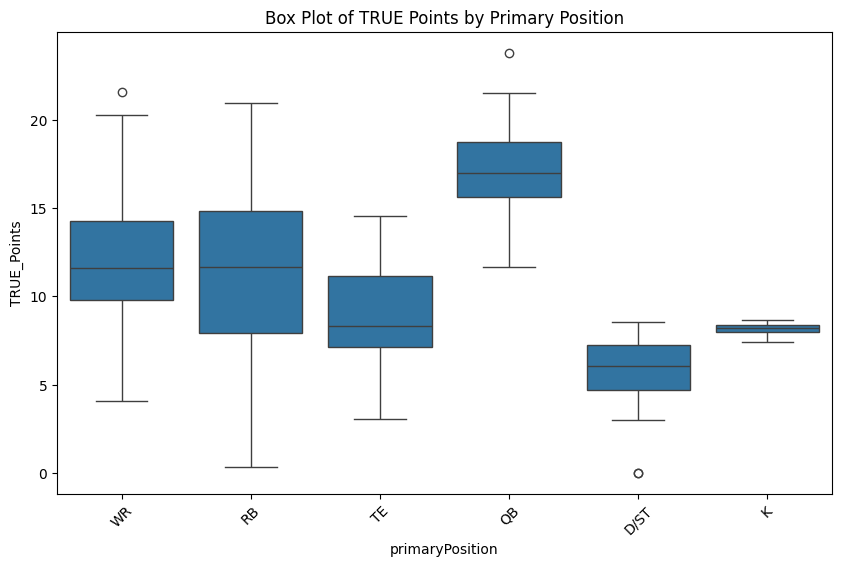

In [97]:
# Box plot for 'points'
plt.figure(figsize=(10, 6))
sns.boxplot(x='primaryPosition', y='points', data=LINEUPS[(LINEUPS['player_active_status'] == 'active') & (~LINEUPS['primaryPosition'].isin(['DE', 'DT', 'CB', 'S', 'LB'])) & (LINEUPS['week'] <= 6)])
plt.title('Box Plot of Points by Primary Position')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

# Box plot for 'TRUE_Points'
plt.figure(figsize=(10, 6))
sns.boxplot(x='primaryPosition', y='TRUE_Points', data=LINEUPS[(LINEUPS['player_active_status'] == 'active') & (~LINEUPS['primaryPosition'].isin(['DE', 'DT', 'CB', 'S', 'LB'])) & (LINEUPS['week'] < 6)])
plt.title('Box Plot of TRUE Points by Primary Position')
plt.xticks(rotation=45)
plt.show()

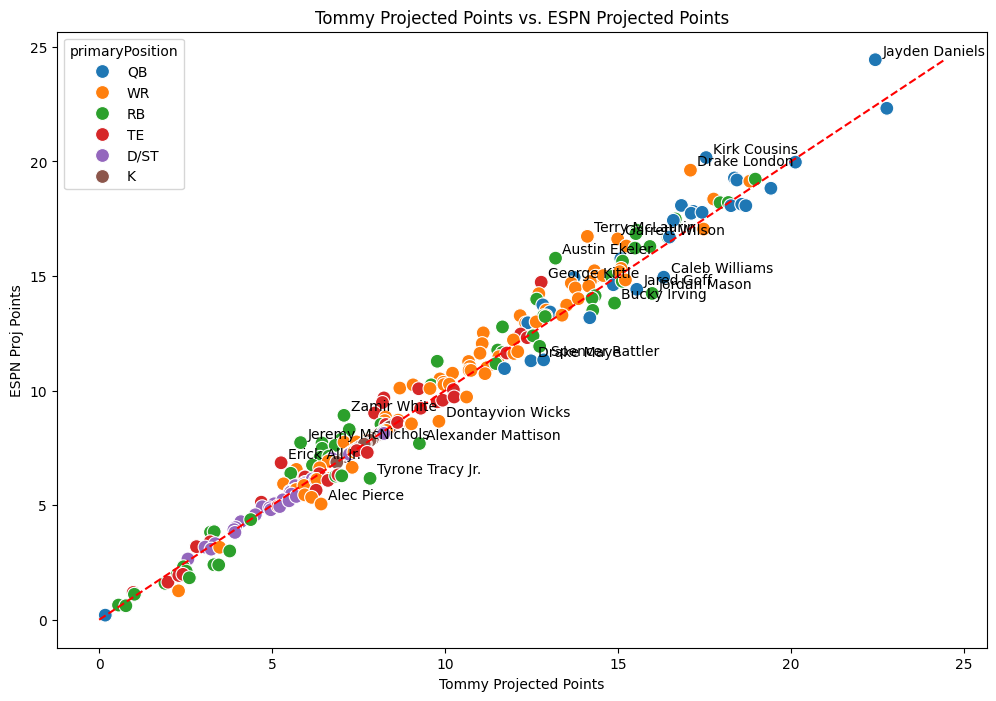

In [98]:
def plot_proj(df, week):

    df['projDiff'] = df['TRUE_Points'] - df['projPoints']

    df = df[(df['projPoints'] > 0) & (df['week'] == week)].groupby(['primaryPosition', 'player_name'])[['points', 'projPoints', 'TRUE_Points', 'projDiff']].mean().sort_values(['projDiff'], ascending=True)
    df = df.reset_index()

    # Get the top 10 highest and 10 lowest values of projDiff
    top_10_projDiff = df[~df['primaryPosition'].isin(['CB', 'S', 'LB', 'DE', 'DT', 'D/ST'])].nlargest(10, 'projDiff')
    bottom_10_projDiff = df[~df['primaryPosition'].isin(['CB', 'S', 'LB', 'DE', 'DT', 'D/ST'])].nsmallest(10, 'projDiff')

    # Combine the top and bottom values into one DataFrame
    top_bottom_projDiff = pd.concat([top_10_projDiff, bottom_10_projDiff])


    plt.figure(figsize=(12, 8))

    scatter_plot = sns.scatterplot(
        x='TRUE_Points', 
        y='projPoints', 
        hue='primaryPosition',  # Color by primaryPosition
        data=df, 
        s=100  # Adjust point size if needed
    )

    # Add labels for each player_name
    for line in range(0, top_bottom_projDiff.shape[0]):
        scatter_plot.text(
            top_bottom_projDiff.TRUE_Points.iloc[line]+0.2,  # Slightly offset the labels on the x-axis
            top_bottom_projDiff.projPoints.iloc[line]+0.2, 
            top_bottom_projDiff.player_name.iloc[line], 
            horizontalalignment='left', 
            size='medium', 
            color='black'
        )

    # Add a line with slope=1 and intercept=0 (line of equality)
    max_val = max(df['TRUE_Points'].max(), df['projPoints'].max())  # Find the maximum value for the plot limit
    plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='y = x')

    # Set plot title and labels
    plt.title('Tommy Projected Points vs. ESPN Projected Points')
    plt.ylabel('ESPN Proj Points')
    plt.xlabel('Tommy Projected Points')

    # Show the plot
    plt.show()

plot_proj(LINEUPS, 6)

### Simulation Sandbox

In [99]:
sim = django_simulation(league=league, n_simulations=500)

# Convert each list to a DataFrame
df_general = pd.DataFrame(sim[0])
df_position_odds = pd.DataFrame(sim[1])
df_standings = pd.DataFrame(sim[2])

# Merge DataFrames on 'team' and 'owner' columns (assuming they are common keys)
df_merged = df_general.merge(df_position_odds, on=['team', 'owner'], suffixes=('_general', '_odds'))
df_final = df_merged.merge(df_standings, on=['team', 'owner'], suffixes=('', '_standings'))

print(df_final.sort_values(by=['projected_wins'], ascending=[False]))

playoff_odds_swing(league = league, week = 5)

# Power Rankings
print(pd.DataFrame(django_power_rankings(league=league, week=5)))

Simulating from week 6 to 14


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   24.0s finished


                      team              owner  projected_wins  \
1            The Fireballz           Corson P            11.0   
0            Team Crenshaw    Miller Crenshaw            10.9   
2             PetroDragons    Bryan Stieneker             9.1   
3                 FapTitan     Robert Cooleen             8.5   
5             Josh n Tots       Walker Thomas             8.3   
7             Team Knutson      Peter Knutson             6.9   
4     Broadway Buttlickers    Thomas Freeland             6.6   
8                Team Ryan       Patrick Ryan             6.2   
6    Team Animated Milkers  Charlie Voudouris             5.9   
11      Tacos y enchiladas       Andrew Blair             5.6   
13  Atlanta Dream Superfan         Sam Boxley             4.9   
10            Tony P's Hog     Turner Banwell             4.9   
9         Senorita Awesome     Tommy Winfield             4.7   
12   Cantrell Underdog Men      Alex Cantrell             4.6   

    projected_losses  pr

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.8s finished


Simulating from week 6 to 14


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.2s finished


Simulating from week 6 to 14


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.4s finished


Simulating from week 6 to 14


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.1s finished


Simulating from week 6 to 14


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.5s finished


Simulating from week 6 to 14


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.4s finished


Simulating from week 6 to 14


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.1s finished


Simulating from week 6 to 14


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.0s finished


Simulating from week 6 to 14


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.6s finished


Simulating from week 6 to 14


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.2s finished


Simulating from week 6 to 14


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished


Simulating from week 6 to 14


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.3s finished


Simulating from week 6 to 14


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.3s finished


Simulating from week 6 to 14


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    3.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.2s finished


                      team  value              owner
0            The Fireballz  34.25           Corson P
1            Team Crenshaw  32.90    Miller Crenshaw
2             PetroDragons  26.15    Bryan Stieneker
3                 FapTitan  25.80     Robert Cooleen
4             Josh n Tots   24.55      Walker Thomas
5     Broadway Buttlickers  22.80    Thomas Freeland
6             Team Knutson  22.20      Peter Knutson
7    Team Animated Milkers  20.95  Charlie Voudouris
8                Team Ryan  20.90       Patrick Ryan
9       Tacos y enchiladas  20.00       Andrew Blair
10  Atlanta Dream Superfan  17.05         Sam Boxley
11        Senorita Awesome  16.80     Tommy Winfield
12            Tony P's Hog  15.75     Turner Banwell
13   Cantrell Underdog Men  15.70      Alex Cantrell


### Historical Stats

- **Efficiency**
    - The rate at which a team starts an optimal lineup

In [100]:
league_history = scrape_team_stats(league_id=lg_vars[select_league]['ID'],
        start_year=lg_vars[select_league]['start'],
        end_year=lg_vars[select_league]['end'],
        swid=lg_vars[select_league]['SWID'],
        espn_s2=lg_vars[select_league]['ESPN_S2'])

league_history = league_history[(league_history['year'] <= 2023) | ((league_history['year'] == 2024) & (league_history['week'] <= 5))]

weekly_stats_analysis(df=league_history, year=2024, week=5)
print(" ")
season_stats_analysis(league=league, df=league_history, week=5)
print(" ")
all_time_stats_analysis(league=league, df=league_history)

#h2h_build(df = league_history, owner1 = 'Tommy Winfield', owner2='Corson P')


[BUILDING LEAGUE] Fetching historical stats for 2022...
BUILDING 2022 Season For Knights FFL  

[BUILDING LEAGUE] Fetching historical stats for 2023...
BUILDING 2023 Season For Knights FFL  

[BUILDING LEAGUE] Fetching historical stats for 2024...
BUILDING 2024 Season For Knights FFL  
----------------------------------------------------------------
|                        Week  5 Analysis                      |
----------------------------------------------------------------
League-wide POSITIVE stats
--------------------------
Peter Knutson had the 2nd highest team_score (180.32 pts) in league history
Peter Knutson had the 1st highest team_score_adj (191.66 pts) in league history
Patrick Ryan had the 1st highest lineup_efficiency (1.00 pts) in league history
Peter Knutson had the 3rd highest best_trio (93.92 pts) in league history
Peter Knutson had the 1st highest WR_pts (37.35 pts) in league history


Franchise POSITIVE stats
--------------------------
Peter Knutson had the 1st hi

In [ ]:
years = range_values = list(range(2024, 2025))
weeks = range_values = list(range(1, 17))
lab = f"{select_league} - Historical Stats From {years[0]} to {years[-1]}"

team_stats_list = []
for y in years:
    league = fetch_league(
        league_id=lg_vars[select_league]['ID'],
        year=y,
        swid=lg_vars[select_league]['SWID'],
        espn_s2=lg_vars[select_league]['ESPN_S2']
    )
    for week in weeks:
        for i in league.teams:
            # Init DF
            team_stats = {}

            # Teams
            team_lineup = get_lineup(league, i, week=week)
            opp_lineup = get_opp_lineup(league, i, week=week)

            # League Information
            team_stats['leagueName'] = league.name

            # Time
            team_stats['year'] = y
            team_stats['week'] = week

            # Team Information
            team_stats['teamID'] = i.team_id
            team_stats['teamOwner'] = i.owner


            # Efficiency Stats
            team_stats['trueScore'] = np.sum([player.points for player in team_lineup if player.slot_position not in ("BE", "IR")])
            team_stats['bestScore'] = get_best_lineup(league, team_lineup)
            team_stats['efficiencyScore'] = get_lineup_efficiency(league, team_lineup)
            team_stats['projAdherance'] = get_idiot_score(league, team_lineup)
            team_stats['scoreDifference'] = get_score_surprise(league, team_lineup)

            # OppStats
            team_stats['opp_trueScore'] = np.sum([player.points for player in opp_lineup if player.slot_position not in ("BE", "IR")])
            team_stats['opp_bestScore'] = get_best_lineup(league, opp_lineup)
            team_stats['opp_efficiencyScore'] = get_lineup_efficiency(league, opp_lineup)
            team_stats['opp_projAdherance'] = get_idiot_score(league, opp_lineup)
            team_stats['opp_scoreDifference'] = get_score_surprise(league, opp_lineup)

            # Differences
            team_stats['margin'] = team_stats['trueScore'] - team_stats['opp_trueScore']
            team_stats["optimalMargin"] = team_stats['bestScore'] - team_stats['opp_bestScore']
            team_stats["efficiencyMargin"] = team_stats['efficiencyScore'] - team_stats['opp_efficiencyScore']
            team_stats["scoreDifferenceMargin"] = team_stats['scoreDifference'] - team_stats['opp_scoreDifference']

            # Outcomes
            team_stats['isWin'] = np.where(team_stats['margin'] > 0, 1, 0)
            team_stats['isTie'] = np.where(team_stats['margin'] == 0, 1, 0)
            team_stats['isLoss'] = np.where(team_stats['margin'] < 0, 1, 0)
            team_stats['isOptimalWin'] = np.where(team_stats['optimalMargin'] > 0, 1, 0)
            team_stats['isOptimalTie'] = np.where(team_stats['optimalMargin'] == 0, 1, 0)
            team_stats['isOptimalLoss'] = np.where(team_stats['optimalMargin'] < 0, 1, 0)
            team_stats['netWinsAdded'] = np.where((team_stats['isWin'] == 1) & (team_stats['isOptimalWin'] == 0), 1, 0)
            team_stats['netLossAdded'] = np.where((team_stats['isLoss'] == 1) & (team_stats['isOptimalWin'] == 1), 1, 0)
            team_stats['netLuck'] = team_stats['netWinsAdded'] - team_stats['netLossAdded']

            # Luck
            try:
                team_stats['luckIndex'] = get_weekly_luck_index(league=league, team = i, week=week)
            except:
                team_stats['luckIndex'] = 0

            # Append
            if y < 2024 or (y == 2024 and week < 3):
                team_stats_list.append(team_stats)
                
team_stats_df = pd.DataFrame(team_stats_list)


In [ ]:
# Group By # , 'year'
hist_stats_df = team_stats_df.groupby(['leagueName', 'week', 'teamID', 'teamOwner']).agg(
    Efficency = ('efficiencyScore', 'mean'),
    W=("isWin", "sum"),
    L=("isLoss", "sum"),
    T=("isTie", "sum"),
    xW=("isOptimalWin", "sum"),
    xL=("isOptimalLoss", "sum"),
    xT=("isOptimalTie", "sum"),
    Luck_W=("netLuck", "sum"),
    TruePF=('trueScore', 'mean'),
    OptimalPF=('bestScore', 'mean'),
    TruePA=('opp_trueScore', 'mean'),
    OptimalPA=('opp_bestScore', 'mean'),
    AdhereProj = ('projAdherance', 'mean'),
    TrueMargin = ('margin', 'mean'),
    #OptimalMargin = ('optimalMargin', 'mean'),
    #PF_OnTable = ('scoreDifference', 'mean'),
    Luck_Index = ('luckIndex', 'mean')
    ).reset_index()\
     .sort_values(by=['Luck_Index'], ascending=False)

print(lab)
hist_stats_df

In [ ]:
# Mapping
years = hist_stats_df['year'].sort_values(ascending=False).unique()
cmap = plt.get_cmap('tab10')
color_dict = {year: cmap(i) for i, year in enumerate(years)}

# Plotting
plt.figure(figsize=(12, 8))

plt.scatter(
    hist_stats_df['AdhereProj'],
    hist_stats_df['Efficency'],
    c=hist_stats_df['year'].map(color_dict),
    label='Data Points')

# Adding labels
texts = []
for i in range(len(hist_stats_df)):
    owner_year = f"{hist_stats_df['teamOwner'][i]}"
    texts.append(plt.text(hist_stats_df['AdhereProj'][i], hist_stats_df['Efficency'][i],
                          owner_year, fontsize=9, ha='center'))
    
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='red', lw=0.5))

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_dict[year], markersize=10) 
           for year in years]
plt.legend(handles, years, title="Year")
    

plt.xlabel('Adherance To ESPN Projections')
plt.ylabel('Correct Start Rate')
plt.title('Scatter Plot of Adherance To Projections vs. Correct Start Rate')
plt.grid(True)
plt.show()

## Projections

In [ ]:
years = range_values = list(range(2024, 2025))
stats_df = pd.DataFrame()
for y in years:
        ply_stats = get_stats_by_matchup(league_id=lg_vars[select_league]['ID'],
                year=y,
                swid=lg_vars[select_league]['SWID'],
                espn_s2=lg_vars[select_league]['ESPN_S2'])
        
        stats_df = pd.concat([stats_df, ply_stats]).fillna(0)


stats_df.head()

In [ ]:
stats_df['diff'] = stats_df['points'] - stats_df['projPoints']
# Set up plot area
plt.figure(figsize=(12, 8))

# Create a violin plot for each primaryPosition
sns.violinplot(x='slotPosition', y='points', data=stats_df)

# Labels and title
plt.xlabel('Primary Position')
plt.ylabel('Points')
plt.title('Distribution of Points by Primary Position')

# Show plot
plt.show()

In [ ]:
stats_df = stats_df[stats_df['week'] < 3]
grouped_df = stats_df[stats_df['week'] < 3].groupby(['year','week', 'primaryPosition', 'player_name'])

positions = stats_df['primaryPosition'].unique()

# Set up plot area
plt.figure(figsize=(20, 12))

# Loop through each primaryPosition
for pos in positions:
    pos_data = stats_df[stats_df['primaryPosition'] == pos]
    
    # Scatter plot
    plt.scatter(pos_data['points'], pos_data['projPoints'], label=pos)

    # Calculate R² using Linear Regression
    X = pos_data['points'].values.reshape(-1, 1)
    y = pos_data['projPoints'].values
    model = LinearRegression().fit(X, y)
    r2 = r2_score(y, model.predict(X))

    # Display R² value
    plt.text(pos_data['points'].mean(), pos_data['projPoints'].mean(), f"R²: {r2:.2f}", fontsize=9)

# Labels and legend
plt.xlabel('Points')
plt.ylabel('Projected Points')
plt.title('Points vs Projected Points by Primary Position')
plt.legend(title="Primary Position")
plt.show()

In [ ]:
# Get unique positions
positions = stats_df['player_name'].unique()

# Set up multi-plot grid
n_cols = 3
n_rows = (len(positions) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten()

# Loop through each player_name and create scatter plots
for i, pos in enumerate(positions):
    pos_data = stats_df[stats_df['player_name'] == pos]
    
    # Scatter plot
    sns.scatterplot(x='points', y='projPoints', data=pos_data, ax=axes[i], color='blue')
    
    # Calculate R² using Linear Regression
    X = pos_data['points'].values.reshape(-1, 1)
    y = pos_data['projPoints'].values
    model = LinearRegression().fit(X, y)
    r2 = r2_score(y, model.predict(X))
    
    # Add R² value to the plot
    axes[i].text(0.05, 0.95, f'R²: {r2:.2f}', transform=axes[i].transAxes, fontsize=12, verticalalignment='top')
    
    # Set title and labels
    axes[i].set_title(f"Primary Position: {pos}")
    axes[i].set_xlabel('Points')
    axes[i].set_ylabel('Projected Points')

# Remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and show plot
plt.tight_layout()
plt.show()

### Positional Variance Between Projections and Actual

### Power Rankings

In [ ]:
league.power_rankings(league.current_week)

In [ ]:
get_season_luck_indices(league, week)